In [1]:
import numpy as np

from dask.delayed import delayed
from dask.base import compute
from dask.diagnostics.progress import ProgressBar

from symbolic_regression.methods.gp import GP
from symbolic_regression.methods.gpshap import GPSHAP
from symbolic_regression.methods.gpcmi import GPCMI
from symbolic_regression.methods.rfgp import RFGP

from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split, process_task
from symbolic_regression.utils.pysr_utils import results_to_dataframe, plot_results

from symbolic_regression.datasets import load_datasets

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 6
test_size = 0.2
val_size = 0.25
n_top_features = None
ns = 100
ci = 0.99
k = 5
record_interval = 5
n_submodels = 2

pysr_params = {
    "populations": 4,
    "population_size": 50,
    "niterations": 60,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0,
}

dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
datasets.keys()

dict_keys(['F1'])

In [3]:
gp_params = {
    "loss_function": nrmse_loss,
    "record_interval": record_interval,
    **pysr_params,
}

gpshap_params = {
    **gp_params
}

gpcmi_params = {
    "ns": ns,
    "ci": ci,
    "k": k,
    **gp_params
}

shap_params = {
    "test_size": test_size,
    "val_size": val_size,
    "n_runs": n_runs,
    "n_top_features": n_top_features,
    **gp_params,
}

rfgpcmi_params = {
    "n_submodels": n_submodels,
    "method_class": GPCMI,
    "method_params": gpcmi_params
}

In [4]:
gp = GP(**gp_params)
gpshap = GPSHAP(**gpshap_params)
gpcmi = GPCMI(**gpcmi_params)
rfgpcmi = RFGP(**rfgpcmi_params)

methods = {
    # "GP": gp,
    # "GPSHAP": gpshap,
    "GPCMI": gpcmi,
    "RFGPCMI": rfgpcmi,
}

width_method = max([round(len(name), 0) for name in methods.keys()])
width_dataset = max([round(len(name), 0) for name in datasets.keys()])

n_records = methods[list(methods.keys())[0]].n_records
n_records

12

In [ ]:
# Sequential execution of tasks

results = {}
equations = {}
features = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new tasks

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}
    train_val_test_sets = []

    X = dataset["X"]
    y = dataset["y"]

    for _ in range(n_runs):
        train_val_test_set = train_val_test_split(X, y)
        train_val_test_sets.append(train_val_test_set)

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name:<{width_method}} on {dataset_name:<{width_dataset}} ", end="")

        if (method_name == "GPSHAP"):
            if equations[dataset_name].get('GP', False):
                X_trains = tuple([train_val_test_set[0] for train_val_test_set in train_val_test_sets])
                gp_equations = [eqs[-1] for eqs in equations[dataset_name]['GP']]
                
                method.precompute_features_from_pretrained_models(X_trains, gp_equations, n_top_features)
            
            else: method.precompute_features(X, y, **shap_params)

        for run in range(n_runs):
            print(".", end="")

            temp_losses, temp_best_eqs, temp_features = method.run(
                train_val_test_sets[run]
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_losses[0]
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_losses[1]
            results[dataset_name][method_name]["test_losses"][run, :] = temp_losses[2]
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(temp_features)

        print("Done")

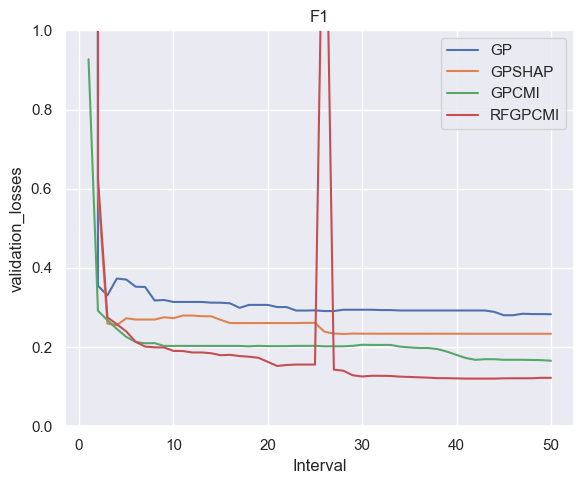

In [118]:
# metrics = 'training_losses'
metrics = 'validation_losses'
# metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
axes[0].set_ylim((0, 1))  # Adjust y-axis limits for better visibility
plt.tight_layout()

plt.show()

In [188]:
# NOTE: The following code is for parallel processing of tasks across datasets and methods.

delayed_tasks = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new task

for dataset_name, dataset in datasets.items():
    delayed_tasks[dataset_name] = {}

    X = dataset["X"]
    y = dataset["y"]

    delayed_splits = [delayed(train_val_test_split)(X, y) for _ in range(n_runs)]
    
    for method_name, method in methods.items():
        delayed_tasks[dataset_name][method_name] = []

        if method_name == "GPSHAP": continue  # Skip GPSHAP for now, as it requires precomputed features

        # Create a delayed task for each method and dataset
        for run in range(n_runs):
            delayed_tasks[dataset_name][method_name].append(
                delayed(process_task)(dataset_name, method_name, run, delayed_splits[run], method)
            )
    
    if ("GPSHAP" in methods):
        if ('GP' in methods):
            delayed_X_trains = tuple([delayed_split[0] for delayed_split in delayed_splits])
            delayed_gp_equations = [delayed_task['equations'][-1] for delayed_task in delayed_tasks[dataset_name]["GP"]]
            
            # Use GP's equations for GPSHAP
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features_from_pretrained_models)(
                delayed_X_trains, delayed_gp_equations, n_top_features
            )

        else:
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features)(
                X, y, **shap_params
            )

        for run in range(n_runs):
            delayed_tasks[dataset_name]["GPSHAP"].append(
                delayed(process_task)(dataset_name, 'GPSHAP', run, delayed_splits[run], methods["GPSHAP"], delayed_precomputed_features_task)
            )

tasks_to_run = [
    task 
    for methods_dict in delayed_tasks.values() 
    for task_list in methods_dict.values() 
    for task in task_list
]

with ProgressBar():
    computed_results = compute(*tasks_to_run, scheduler='processes')

results = {}
equations = {}
features = {}

for dataset_name in datasets.keys():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}

    for method_name in methods.keys():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

for result in computed_results:
    dataset_name = result['dataset_name']
    method_name = result['method_name']
    run = result['run']
    
    results[dataset_name][method_name]["training_losses"][run, :] = result['losses'][0]
    results[dataset_name][method_name]["validation_losses"][run, :] = result['losses'][1]   
    results[dataset_name][method_name]["test_losses"][run, :] = result['losses'][2]
    
    equations[dataset_name][method_name].append(result['equations'])
    features[dataset_name][method_name].append(result['features'])

[########################################] | 100% Completed | 18m 19s


<lambdifygenerated-672>:2: RuntimeWarning: invalid value encountered in sqrt
  return (2*absorbance_36 - principal_component_3 + 1.0300245)*(-absorbance_17 + absorbance_36 + absorbance_45 - absorbance_95 - principal_component_3 + sqrt(absorbance_56 + principal_component_3)) + 0.47114295
<lambdifygenerated-673>:2: RuntimeWarning: invalid value encountered in sqrt
  return (sqrt(absorbance_36) + 2*absorbance_36 - principal_component_3)*(-absorbance_17 + absorbance_36 + absorbance_45 - absorbance_95 - principal_component_3 + sqrt(absorbance_56 + principal_component_3)) + 0.47114295
<lambdifygenerated-674>:2: RuntimeWarning: invalid value encountered in sqrt
  return (3*absorbance_36 - principal_component_3 - 2.4624343)*(-absorbance_17 + absorbance_36 + absorbance_45 - absorbance_95 - principal_component_3 + sqrt(absorbance_56 + principal_component_3)) + 2.4909775
<lambdifygenerated-675>:2: RuntimeWarning: invalid value encountered in sqrt
  return (2*absorbance_36 - principal_component_3 

In [189]:
import pickle
import datetime

In [190]:
data = {
    "results": results,
    "equations": equations,
    "features": features
}
timestamp = datetime.datetime.now().strftime("%Y-%m-%d__%H-%M-%S")
filename = f"data_{timestamp}.pickle"
with open(filename, "wb") as f:
    pickle.dump(data, f)
print(f"\nResults saved to {filename}")


Results saved to data_2025-07-30__00-20-04.pickle


In [213]:
data = pickle.load(open('data_2025-07-30__09-34-10.pickle', "rb"))
results, features, equations = data['results'], data['features'], data['equations']

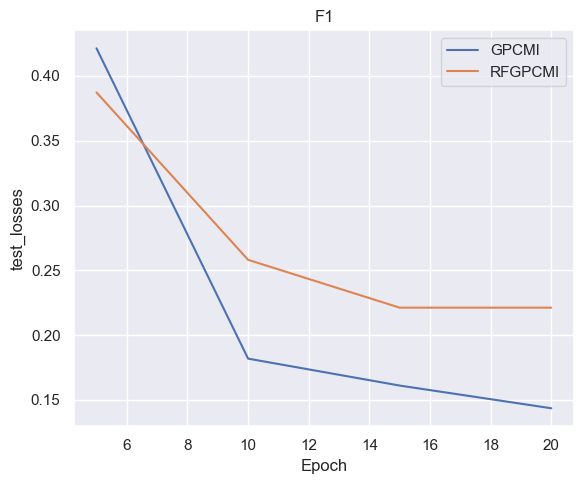

In [214]:
# metrics = 'training_losses'
# metrics = 'validation_losses'
metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']

fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))

    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.median(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Epoch")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
# axes[0].set_ylim((0, 1))
plt.tight_layout()

plt.show()

In [215]:
from copy import deepcopy

results_copy = deepcopy(results)

for dataset_name in results.keys():
    for method in results[dataset_name].keys():
        for metric in results[dataset_name][method].keys():
            results_copy[dataset_name][method][metric] = results[dataset_name][method][metric][:, -1]

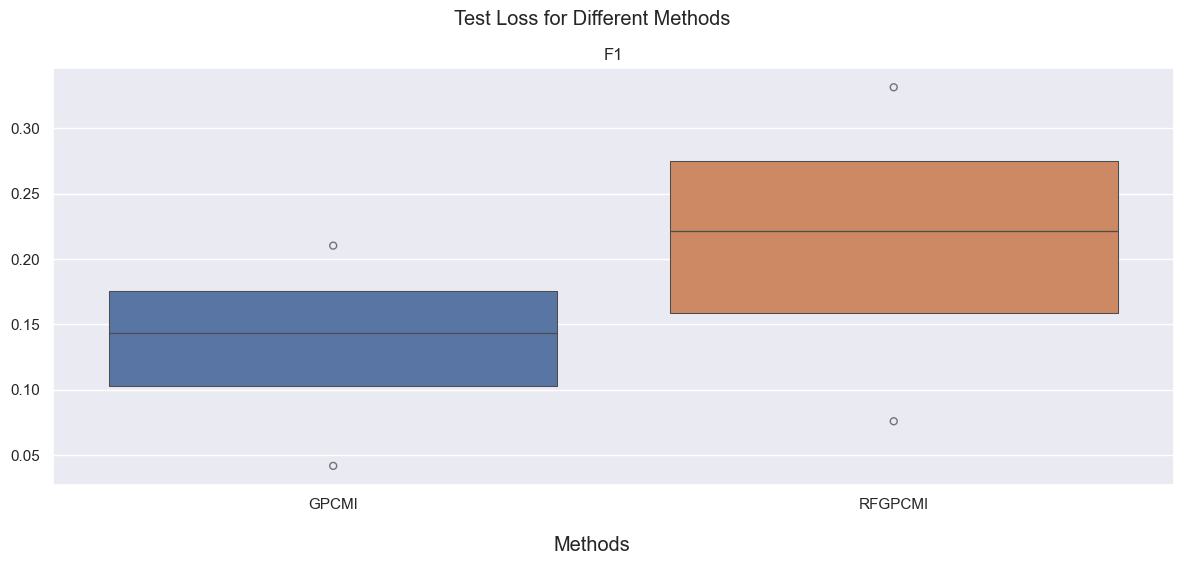

In [216]:
# Convert results to DataFrame    
df_results = results_to_dataframe(results_copy)

fig, axes = plot_results(
    df_results, 
    # nrows=2, 
    # ncols=None, 
    # group_level="model",
    # value_level="metric", 
    value_key="test_losses"
    # value_key="validation_losses",
    # value_key="training_losses"
)

fig.figure.set_size_inches(12, 5)
fig.tight_layout(w_pad=0.5)
fig.suptitle("Test Loss for Different Methods", y=1.04)
# fig.supylabel("Test Loss", x=-.02)
fig.supxlabel("Methods", y=-.05)

# axes[0].set_ylim(-.001, 0.025)
# axes[1].set_ylim(.1, 0.2)
plt.show()

In [207]:
for dataset_name in features.keys():
    print(f"{dataset_name} features:")
    for method in features[dataset_name].keys():
        a = features[dataset_name][method]

        if isinstance(a[0], str):
            print(f"{method}: {len(a)}")
        else:

            if isinstance(a[0][0], str):
                b = list(map(lambda x: len(x), a))
                mean_x = np.mean(b)
            else:
                c = list(map(lambda x: len(set([item for sublist in x for item in sublist])), features[dataset_name][method]))
                mean_x = np.mean(c)

            print(f"{method}: {mean_x:.0f}")
    print()
            

F1 features:
GP: 53
GPSHAP: 6
GPCMI: 3
RFGPCMI: 4



In [208]:
df_results

dataset              F1                                                \
method               GP                                        GPSHAP   
metric  training_losses validation_losses test_losses training_losses   
run                                                                     
0              0.111106          0.172566    0.133552        0.050303   
1              0.092784          0.189355    0.135975        0.005075   
2              0.029066          0.057365    0.043103        0.012695   
3              0.051063          0.069366    0.139715        0.002020   

dataset                                                                  \
method                                          GPCMI                     
metric  validation_losses test_losses training_losses validation_losses   
run                                                                       
0                0.091874    0.064862        0.062707          0.087826   
1                0.010738    0.007398        0.017591          0.016116   
2                0.023190    0.023205        0.022009          0.014887   
3                0.002764    0.003424        0.269075          0.368137   

dataset                                                            
method                      RFGPCMI                                
metric  test_losses training_losses validation_losses test_losses  
run                                                                
0          0.065532        0.078251          0.129785    0.080349  
1          0.036927        0.062234          0.121280    0.238854  
2          0.017093        0.022210          0.045699    0.029335  
3          0.456000        0.005546          0.007722    0.015425

In [179]:
a = [1,1,1,1,2]

In [180]:
np.mean(a), np.median(a), np.std(a)

(1.2, 1.0, 0.4)

In [7]:
from symbolic_regression.feature_selections.cmi import select_features as sf_cmi

In [8]:
X, y = datasets['F1']['X'], datasets['F1']['y']

In [12]:
sf_cmi(
    X, 
    y, 
    ns=10000,
    ci=ci, 
    k=k,
)

(['X2', 'X1', 'X3'],
 [0.5951836148762437, 0.47042391149950347, 0.21195857718326508])